# **Analysis of the Meteorological Variables**

In this notebook a comprehensive processing of the obtained meteorological data is made, with the objective of selecting and analyzing relevant variables for the model.  
The workflow includes analysis of temporal and spatial variance, and the evaluation of linear and non-linear correlation with the target variable.

## Process Outline

1. **Temporal variance analysis:**  
    Identification of variables with low variability over time.

2. **Spatial variance analysis:**  
    Detection of variables with low variability across space.

3. **Linear correlation:**  
    Calculation of the Pearson correlation between each variable and the target variable.

4. **Non-linear correlation:**  
    Evaluation of non-linear dependency using mutual information.

---

This process allows reducing the dimensionality of the dataset and selecting the most informative variables for the TFT model.

In [5]:
# Import necessary libraries 
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression

In [ ]:
# Read all the datasets

# 1. Data with the field mean (fldmean)
variable_analysis_fldmean_ds = xr.open_dataset("input_data/variable_analysis/variable_analysis_fldmean.nc")
# 2. Data with the time variance (timvar)
variable_analysis_timvar_ds = xr.open_dataset("input_data/variable_analysis/variable_analysis_timvar.nc")
# 3. Data with the spatial variance (fldvar)
variable_analysis_fldvar_ds = xr.open_dataset("input_data/variable_analysis/variable_analysis_fldvar.nc")

## Temporal variance analysis

First step is to analyze the time variance of the variables in order to detect the constant over time variables, as they will not have impact on the temperature.

In [7]:
# With a squeeze of the dataset we can clean the dims with size 1
timvar = variable_analysis_timvar_ds.squeeze()

# Now we made the spatial mean over the time variance on the dimensions that are not the bounds (lat, lon).
spatial_dims = [d for d in timvar.dims if d not in ("bnds")]
timvar_mean = timvar.mean(dim=spatial_dims)

# And eliminate the bounds dimensions
to_mean = [d for d, s in timvar_mean.sizes.items() if d != "time" and s > 1]
timvar_mean_clean = timvar_mean.mean(dim=to_mean)

# Get the values of the mean time variance for each variable.
scores = {}
for name, da in timvar_mean_clean.data_vars.items():
    # Get the scalar value
    value = da.item()
    scores[name] = value

# Transform into a pandas Series to extract the info.
timvar_series = pd.Series(scores, name="var_time")

# Get the smallest variance variables
low_time = timvar_series.nsmallest(15)
print("15 variables with less time variance:\n\n", low_time)

15 variables with less time variance:

 istl4    0.000000e+00
cl       0.000000e+00
wmb      0.000000e+00
ci       0.000000e+00
slt      0.000000e+00
tvh      0.000000e+00
tvl      0.000000e+00
slor     3.057232e-21
isor     1.455285e-18
cvh      2.315226e-18
cvl      3.249584e-18
lsm      1.209705e-17
anor     6.737307e-17
viozd    2.094456e-16
mser     4.006281e-14
Name: var_time, dtype: float64


Here we can see that there are 13 variables with less than 1e-16 variance. For our purpose, we can consider this value a threshold of the numeric zero for the variance. So we can quit these 13 variables.

In [8]:
var_to_quit_step_1 = list(timvar_series.nsmallest(13).axes[0])
var_to_quit_step_1

['istl4',
 'cl',
 'wmb',
 'ci',
 'slt',
 'tvh',
 'tvl',
 'slor',
 'isor',
 'cvh',
 'cvl',
 'lsm',
 'anor']

Now we repeat the process with the spatial variance.

In [9]:
# With a squeeze of the dataset we can clean the dims with size 1
fldvar = variable_analysis_fldvar_ds.squeeze()

# Now we made the spatial mean over the spatial variance on the dimensions that are not the bounds (lat, lon).
spatial_dims = [d for d in fldvar.dims if d not in ("bnds")]
fldvar_mean = fldvar.mean(dim=spatial_dims)
to_mean = [d for d, s in fldvar_mean.sizes.items() if d != "time" and s > 1]
fldvar_mean_clean = fldvar_mean.mean(dim=to_mean)

# Get the values of the mean spatial variance for each variable.
scores = {}
for name, da in fldvar_mean_clean.data_vars.items():
    # Get the scalar value
    val = da.item()
    scores[name] = val

# Transform into a pandas Series to extract the info.
fldvar_series = pd.Series(scores, name="var_time")

# Get the smallest variance variables
low_time = fldvar_series.nsmallest(15)
print("15 variables with less spatial variance:\n\n", low_time)

15 variables with less spatial variance:

 istl4     0.000000e+00
ci        0.000000e+00
viozd     1.816064e-16
mser      3.901111e-14
es        5.056178e-13
mcsr      4.539563e-12
csfr      1.819203e-11
msmr      3.263750e-11
mssror    4.762904e-11
csf       5.883270e-11
mlssr     8.921913e-11
msr       1.028540e-10
lssfr     1.040841e-10
viiwd     1.123044e-10
mper      2.068044e-10
Name: var_time, dtype: float64


In this case there are only 2 variables with less than 1e-16 variance, and they coincide with the no time variance, so they are constant. At this point we can not elimiante more variables without modifying our thresghold.

Now we are going to analyze the linear correlation with the Pearson Correlation coeficient. To get this correlation of the exogenous variables with the temperature we need to use a time series. Because of this we are going to use the field mean dataset, which contains only a time series with the field mean on each time step.

In [10]:
# Prepare de dataset
fldmean_ds = variable_analysis_fldmean_ds.squeeze()
to_mean = [d for d, s in fldmean_ds.sizes.items() if d != "time" and s > 1]
fldmean_ds_clean = fldmean_ds.mean(dim=to_mean)
fldmean_ds_clean

<xarray.Dataset>
Dimensions:       (time: 248)
Coordinates:
  * time          (time) datetime64[ns] 2024-01-01 ... 2024-01-31T21:00:00
    lon           float64 0.0
    lat           float64 0.0
    height        float64 10.0
    depth         float64 0.0
    depth_2       float64 7.0
    depth_3       float64 28.0
    depth_4       float64 100.0
    lev           float64 0.0
Data variables: (12/266)
    depth_bnds    float64 3.5
    depth_2_bnds  float64 17.5
    depth_3_bnds  float64 64.0
    depth_4_bnds  float64 50.0
    10u           (time) float32 2.701 2.429 2.346 ... -1.707 -1.548 -1.606
    10v           (time) float32 0.3879 0.7352 0.9229 ... -0.1378 -0.6452 -0.87
    ...            ...
    dwps          (time) float32 0.3582 0.3662 0.3833 ... 0.2811 0.2885 0.2964
    dwww          (time) float32 0.6 0.6232 0.6209 0.559 ... 0.7697 0.751 0.7045
    wsk           (time) float32 0.01257 0.01181 0.01106 ... 0.006695 0.006408
    wsp           (time) float32 5.763 5.908 5.865 5.671 ... 5.393 5.148 4.828
    wss           (time) float32 0.02465 0.02374 0.02294 ... 0.01557 0.01524
    deg0l         (time) float32 2.124e+03 2.09e+03 ... 2.905e+03 2.912e+03

In [11]:
# Transform the datset into a pandas DataFrame
df = (fldmean_ds_clean.to_dataframe().reset_index())
df.describe()

,lon,lat,height,depth,depth_bnds,depth_2,depth_2_bnds,depth_3,depth_3_bnds,depth_4,...,swvl2,swvl3,swvl4,wdw,dwps,dwww,wsk,wsp,wss,deg0l
count,248.0,248.0,248.0,248.0,248.0,248.0,248.0,248.0,248.0,248.0,...,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000
mean,0.0,0.0,10.0,0.0,3.5,7.0,17.5,28.0,64.0,100.0,...,0.139373,0.122387,0.110676,0.547605,0.390705,0.466505,0.011439,4.821050,0.023188,2648.918457
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.005310,0.002982,0.000871,0.067951,0.091734,0.095252,0.005326,0.676015,0.006670,678.624146
min,0.0,0.0,10.0,0.0,3.5,7.0,17.5,28.0,64.0,100.0,...,0.130866,0.118403,0.109556,0.427475,0.250673,0.300116,0.004689,3.215341,0.013508,1518.362671
25%,0.0,0.0,10.0,0.0,3.5,7.0,17.5,28.0,64.0,100.0,...,0.136088,0.119694,0.109903,0.500215,0.315435,0.398434,0.007720,4.354608,0.018181,1881.557007
50%,0.0,0.0,10.0,0.0,3.5,7.0,17.5,28.0,64.0,100.0,...,0.138081,0.121706,0.110357,0.532385,0.370176,0.449595,0.009546,4.778210,0.020895,2827.301025
75%,0.0,0.0,10.0,0.0,3.5,7.0,17.5,28.0,64.0,100.0,...,0.142835,0.125566,0.111579,0.591818,0.458519,0.518998,0.013923,5.321306,0.027086,3141.063904
max,0.0,0.0,10.0,0.0,3.5,7.0,17.5,28.0,64.0,100.0,...,0.151228,0.126538,0.112095,0.687070,0.644136,0.769681,0.030285,6.468009,0.042742,3857.119629


In [12]:
# First, we are going to quit the spatial variables, as the lon, lat and the vertical variables
df_clean = df.drop(columns=["time", "lon", "lat", "height", "depth", "depth_bnds", "depth_2", "depth_2_bnds", "depth_3", "depth_3_bnds", "depth_4", "depth_4_bnds", "lev"])

# We also quit the constant variables, as they will not have valid correlation
df_clean = df_clean.drop(columns = var_to_quit_step_1)
# In this way, only remains the temperature and the exogenous variables
df_clean.head()

,10u,10v,2d,2t,msl,mwd,mwp,sst,swh,sp,...,swvl2,swvl3,swvl4,wdw,dwps,dwww,wsk,wsp,wss,deg0l
0,2.700991,0.387908,279.938293,284.057434,101931.382812,294.032867,9.335699,289.229675,2.870867,98930.179688,...,0.131448,0.118512,0.109556,0.470201,0.358173,0.599958,0.012570,5.763175,0.024646,2124.222168
1,2.429183,0.735237,279.911407,283.749268,101878.546875,291.427032,9.139148,289.229675,2.740747,98874.070312,...,0.131454,0.118515,0.109561,0.488483,0.366152,0.623153,0.011812,5.908064,0.023736,2089.945557
2,2.345809,0.922880,279.904022,283.614410,101873.351562,289.461914,8.919690,289.229675,2.610114,98864.804688,...,0.131466,0.118518,0.109565,0.506700,0.383256,0.620874,0.011060,5.864861,0.022936,2079.168213
3,2.368372,1.450837,280.296387,284.034637,101994.171875,288.259247,8.689755,289.229675,2.485901,98978.742188,...,0.131471,0.118521,0.109570,0.524298,0.404726,0.558979,0.009218,5.670935,0.022453,2115.081787
4,2.749975,2.297479,280.915436,286.194153,101967.687500,286.401337,8.382880,289.229675,2.416959,98967.125000,...,0.131289,0.118448,0.109573,0.530293,0.424989,0.550920,0.009905,5.405506,0.023297,2211.248779


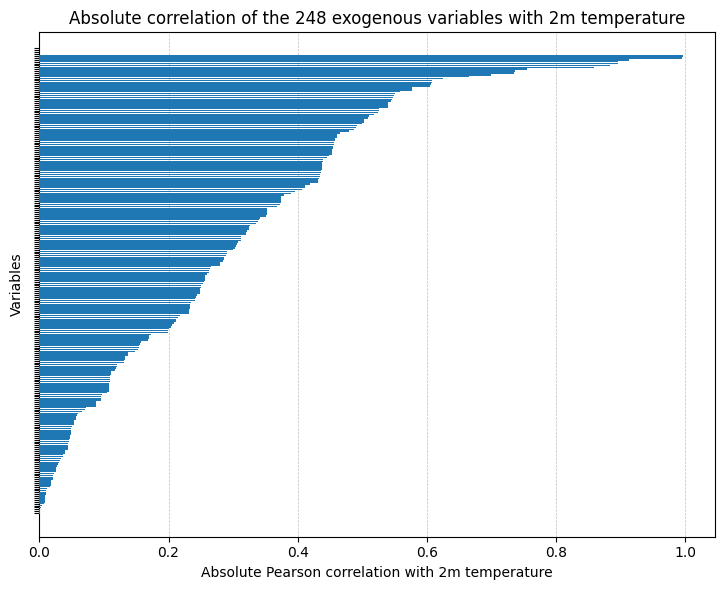

In [13]:
# Split the objetive (2t) with the rest of the variables.
y = df_clean["2t"]
# Get the Pearson correlation
corr = df_clean.corrwith(y, numeric_only=True).drop(labels=["2t"])

# In order to set the title, we need the number of variables
n_bars = len(df_clean.columns) - 1  # -1 because we do not include the temperature

# Order the correlation by values
top = corr.abs().sort_values(ascending=True).index
top_corr = corr[top].abs()

# Make an horizontal barplot
plt.figure(figsize=(8, 6))
plt.barh(top, top_corr, zorder = 3)         
plt.xlabel("Absolute Pearson correlation with 2m temperature") 
plt.title(f"Absolute correlation of the {n_bars} exogenous variables with 2m temperature")
plt.tight_layout()
plt.yticks(top, [])
plt.ylabel("Variables")
plt.grid(True, axis="x", color="gray", linestyle="--", linewidth=0.5, alpha=0.5, zorder=0)
plt.show()

Here we can see that there are a wide range of correlations. From high correlated variables to some with no correlation. At this point, as we need to keep only high value variables we are going to select the variables with a correlation smaller than 0.5. We are not going to eliminate them now, as we need to keep checking the non-linear interactions but we are going to maintain an eye on them. 

At the same time, there are some variables with a NaN correlation. These are probably some of the low time variance variables we have seen before, so we are going to filter them too. 

Also, there are three variables that have a correlation greater than 0.9. These variables are probabily colinear with the objetive, so lets see which variable are them.


In [14]:
vars_high_corr = list(corr[corr > 0.9].index)
vars_low_corr = list(corr[corr < 0.5].index)
vars_nan_corr = list(corr[corr.isna()].index)
print(vars_high_corr)

['mx2t', 'mn2t', 'stl1']


These variables are:

mx2t -> maximum_2m_temperature_since_previous_post_processing: is the maximum 2m temperature since the last post-processing. It has essentially the same information as the 2m temperature, so we will remove it.

mx2t -> minimum_2m_temperature_since_previous_post_processing: is the same as the previous but for the minimum value, so we must also remove it.

stl1 -> soil_temperature_layer_1: is the temperature at ground level. Although it’s not the same as the 2 m temperature, it’s a very similar variable, so we will also remove it.

But before removing all these variables we are going to check the non-linear relationships. We need to check if some of this variables with low correlation have more importance than we can see at first view. To do this, we are going to check the mutual information coefficient. 

In [15]:
# Make an index from the time column
if "time" in df_clean.columns:
    df_clean = df_clean.set_index("time")

# Quit nan values
df_clean = df_clean.dropna()

# Split the temperature and the rest
X = df_clean.drop(columns=["2t"])   
y = df_clean["2t"].values           

# Calculate the mutual information
mi = mutual_info_regression(X, y, random_state=2)
mi_series = pd.Series(mi, index=X.columns, name="MI_with_2t").sort_values(ascending=False)

# Print some values
print(mi_series.head(10))

mx2t          2.498215
mn2t          2.396391
msdwlwrfcs    1.059209
strdc         1.059209
2d            1.009334
skt           0.901056
stl1          0.867148
msshf         0.628271
sshf          0.628271
fal           0.612675
Name: MI_with_2t, dtype: float64


We can see that the three variables that we saw before have a big value of mutual information, specifically the mx2t and mn2t. 

Now we can take a look on the plot with all the MI.

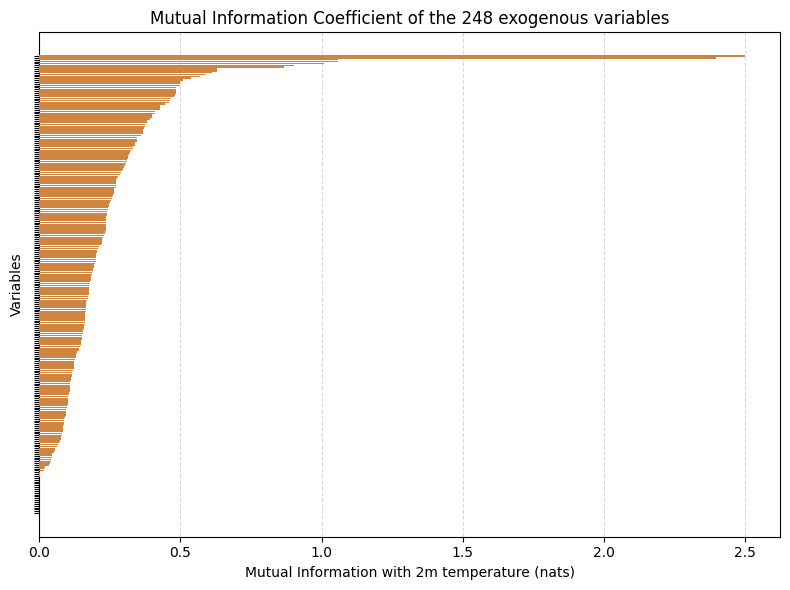

In [16]:
# Get the number of variables
variables = len(mi_series)

# Make the plot of the series
plt.figure(figsize=(8,6))
plt.barh(mi_series.index, mi_series.values, zorder=3, color = "peru")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.5, zorder=0)
plt.xlabel("Mutual Information with 2m temperature (nats)")
plt.title(f"Mutual Information Coefficient of the {variables} exogenous variables")
plt.yticks(mi_series.index, [])
plt.ylabel("Variables")
plt.tight_layout()
plt.show()

We can see that there are the two variables with the higher value, but we can see aswell that the majority of the variables have less than 0.5 nats of mutual information. Now, we are going to set a threshold of 0.3 for the mutual information.

With this threshold, we are going to quit all the variables with less than 0.5 linear correlation and less than 0.3 mutual information. 

In [17]:
vars_low_mi = list(mi_series[mi_series < 0.3].index)

common_var_to_quit = [v for v in vars_low_mi if v in vars_low_corr] + vars_high_corr + var_to_quit_step_1 + vars_nan_corr

print("Variables with low correlation: ", len(vars_low_corr))
print("Variables with low mutual information: ", len(vars_low_mi))
print("Variables with no time variance: ", len(var_to_quit_step_1) + len(vars_nan_corr))
print("Variables to quit: ", len(common_var_to_quit)) 

Variables with low correlation:  217
Variables with low mutual information:  188
Variables with no time variance:  17
Variables to quit:  197


In [18]:
# Clean the dataset
df_clean_post_processed = df.drop(columns=common_var_to_quit)
df_clean_post_processed = df_clean_post_processed.drop(columns=["time", "lon", "lat", "height", "depth", "depth_bnds", "depth_2", "depth_2_bnds", "depth_3", "depth_3_bnds", "depth_4", "depth_4_bnds", "lev"])
df_clean_post_processed.head()

,10v,2d,2t,100v,v10n,rhoao,ewss,e,fal,fsr,...,vilwn,vign,vithen,viman,vitoen,viwvn,swvl2,swvl3,swvl4,deg0l
0,0.387908,279.938293,284.057434,0.306452,0.381601,1.226057,327.905701,-0.000073,0.097150,0.266292,...,-0.008390,-3.909185e+09,-6.482947e+09,-29444.628906,-1.041345e+10,-3.888431,0.131448,0.118512,0.109556,2124.222168
1,0.735237,279.911407,283.749268,0.822248,0.706413,1.225760,314.635162,-0.000073,0.097149,0.266326,...,0.011160,-5.108749e+09,-9.809076e+09,-43513.976562,-1.495039e+10,-4.725618,0.131454,0.118515,0.109561,2089.945557
2,0.922880,279.904022,283.614410,1.084489,0.906363,1.225152,306.204285,-0.000069,0.097155,0.266275,...,-0.010471,-6.680785e+09,-1.446941e+10,-63132.226562,-2.121494e+10,-13.388163,0.131466,0.118518,0.109565,2079.168213
3,1.450837,280.296387,284.034637,1.785626,1.449812,1.225460,298.728546,-0.000068,0.097155,0.266262,...,0.010760,-7.926590e+09,-1.737083e+10,-75685.343750,-2.536430e+10,-12.283649,0.131471,0.118521,0.109570,2115.081787
4,2.297479,280.915436,286.194153,2.807294,2.349457,1.223776,453.816833,-0.000103,0.097097,0.266112,...,0.086933,-8.569972e+09,-1.821955e+10,-80160.687500,-2.682082e+10,2.718596,0.131289,0.118448,0.109573,2211.248779


With this analysis, we now have all the variables that we are going to use in the complete dataset. In order to indentify them on the website we are going to print the full variable name.

In [19]:
short_names  = list(df_clean_post_processed.columns)
for short in short_names:
    long = variable_analysis_fldmean_ds[short].attrs.get("long_name", "<sin long_name>")
    print(f'- "{short}" → "{long}"')


- "10v" → "10 metre V wind component"
- "2d" → "2 metre dewpoint temperature"
- "2t" → "2 metre temperature"
- "100v" → "100 metre V wind component"
- "v10n" → "Neutral wind at 10 m v-component"
- "rhoao" → "Air density over the oceans"
- "ewss" → "Eastward turbulent surface stress"
- "e" → "Evaporation"
- "fal" → "Forecast albedo"
- "fsr" → "Forecast surface roughness"
- "wstar" → "Free convective velocity over the oceans"
- "ie" → "Instantaneous moisture flux"
- "inss" → "Instantaneous northward turbulent surface stress"
- "ishf" → "Instantaneous surface sensible heat flux"
- "lict" → "Lake ice surface temperature"
- "lmld" → "Lake mix-layer depth"
- "lshf" → "Lake shape factor"
- "metss" → "Mean eastward turbulent surface stress"
- "mer" → "Mean evaporation rate"
- "mngwss" → "Mean northward gravity wave surface stress"
- "mntss" → "Mean northward turbulent surface stress"
- "mper" → "Mean potential evaporation rate"
- "msmr" → "Mean snowmelt rate"
- "msdwlwrf" → "Mean surface downw

In addition, on this list we can see that there are some variables that maybe leaking the information of the temperature. In order to not use redundant information of the temperature for the forecast, we are going to quit the following variables:

- lict: Lake ice surface temperature. Is the temperature at the surface of an inland water source. So it can be very similar to the temperature on these water sources at 2m height.
- skt: Skin temperature: It is the temperature at the earth surface, so as the same as the previous one we need to discard this.
- stl2,4: Soil temperature level 2 and 4: are the temperature on a small depth of the surface. These are less redundant but still can be inapropiate to use. 
- tsn: Temperature of the snow layer. It is very similar to lict but with snow-air interface. 
- deg0l: 0 degrees C isothermal level (atm). It is the heigh of the isothermal level of 0 degrees. This is not a temperature measure, but it represent how high is the zero degrees temperature, so we are not going to use it aswell.

With this process, we have 59 remain variables.